**Kalman Filter and its variant**

In this repo, I will implement a kalman filter, extended kalman filter 
and compare their performance.

The system is a simple pendulum and the filters are to track the pendulum's state given by the tuple of its angle and angular velocity (angle is the deviation from the vertical).

In [ ]:
%matplotlib inline

In [ ]:
import numpy as np
import math
from scipy import linalg
import matplotlib.pyplot as plt

**Simple pendulum Model**

$l$ : Length of pendulum

$m$ : Mass of pendulum

$G$ : Acceleration due to gravity

$dt$ : Time step

$\theta_n$ : Angular deviation from vertical at timestep $n$(counter clockwise is positive)

$\dot{\theta}_n$: Angular velocity at timestep $n$

$\theta_{n+1} = \theta_n + \dot{\theta}_n  dt $

$\dot{\theta}_{n+1} = \dot{\theta}_n - \frac {G} {l} \sin(\theta_n) dt$

Measurment of angle:

$z_n = C*\begin{bmatrix}\theta_n\\ \dot{\theta}_n \end{bmatrix} + q$

where $q \sim N(0,Q)$ and $Q$ is a 1x1 variance matrix



In [ ]:
#simulation of a pendulum
class Pendulum:
  '''Pendulum'''
  def __init__(
    self,
    l, #length in meters
    angl0, #initial angle in radians
    avel0, #initial angular velocity in radians/s
    G, #acceleration due to gravity in m/s^2
    R, #process noise co-variance 2x2 matrix
    Q, #measurement co-variance 1x1
    rng_p, #random noise generator for process
    rng_m, #random noise generator for measurement
  ):
    self.angl = angl0
    self.avel = avel0
    self.l = l
    self.G = G
    self.R = R
    self.Q = Q
    self.rng_p = rng_p
    self.rng_m = rng_m

  def step (
      self,
      dt #timestep in seconds
    ):
   
    #sample process noise
    a_n, v_n = self.rng_p.multivariate_normal([0,0],R)
    angl1 = self.avel*dt + self.angl + a_n   
    avel1 = -self.G/self.l*math.sin(self.angl)*dt + self.avel + v_n
    self.avel = avel1
    self.angl = angl1

  def getState (self):
    '''True State: Useful to calculate RMS error'''
    return self.angl, self.avel

  def measure (self):
    '''Actual measurement of position via a sensor'''
    return self.angl + self.rng_m.standard_normal()*self.Q

**Kalman Filter**

Linearize around $\theta = 0$

$\begin{bmatrix}
  \theta_{n+1}\\
  \dot{\theta}_{n+1}
\end{bmatrix}
 = 
 \begin{bmatrix}
  1 & dt\\
  -\frac{G}{l}dt & 1
\end{bmatrix}
\begin{bmatrix}
  \theta_{n}\\
  \dot{\theta}_{n}
\end{bmatrix}
+ $ B*u_n + r_n $

where $r_n \sim N(0,R)$ and R is a 2x2 covariance matrix.

B is a 2x2 input matrix and u_n is the input at time n

Let 
$
A = \begin{bmatrix}
  1 & dt\\
  -\frac{G}{l}dt & 1
\end{bmatrix}
$ the process matrix.

We will model the state as a gaussian as 

$
\begin{bmatrix}
  \theta_n\\
  \dot{\theta}_n
\end{bmatrix}
\sim N(\mu_n,P_n)
$

where

$\mu_n$ is a 2x1 column matrix for the means of the angle and angular velocity and

$P_n$ is the 2x2 process covariance matrix


**The Kalman Filter Equations**

*Predict*

$
\mu_p = A_t \, \mu_{t-1}+B_t\ u_t 
$

$
P_p = A_t \ P_{t-1} A_t^T +R_t
$

*Gain*

$
K = P_p \ C_t^T(C_t \ P_p \ C_t^T +Q_t)^{-1}
$

*Update*

$
\mu_{n+1} = \mu_p+K_t(z_t-C_t \ \mu_p)
$

$
P_n = (I-K_t \ C_t) P_p
$

In [ ]:
class KalmanFilter:
  ''' Kalman Filter'''
  def __init__(
    self,
    mu0, #initial mean of the state
    P0,#Initial State covariance matrix
    R, #Motion covariance matrix
    Q, #Measurement covariance matrix
    A, #motion matrix
    B, #input matrix
    C, #measurement matrix
  ):
    self.mu = mu0
    self.P = P0
    self.R = R
    self.Q = Q
    self.A = A
    self.B = B
    self.C = C
    self.mu_p = mu0 #predictor's mean
    self.P_p = P0  #predictor's covariance

  def step (self,u_t, z_t):
    '''update the posterior based on the measurement and predicted prior
    u_t: input at time t
    z : measurement at time t
    '''
    #prediction Equations
    self.mu_p = np.matmul(self.A,self.mu) + np.matmul(self.B,u_t)
    self.P_p = np.matmul(np.matmul(self.A,self.P),self.A.transpose()) + self.R
    #Kalman. Gain
    inv_mat = np.linalg.inv(np.matmul(np.matmul(self.C,self.P_p),self.C.transpose())+self.Q)
    K = np.matmul(np.matmul(self.P_p,self.C.transpose()),inv_mat)
    #update/correction equation
    self.mu = self.mu_p + K*(z_t - np.matmul(self.C,self.mu_p))
    self.P = np.matmul((np.eye(2)-np.matmul(K,self.C)),self.P_p)

  def probe (self):
    ''' return state '''
    return self.mu, self.P

**Equations for Extended Kalman Filter**

$
\mu_{\theta_{n+1}} = \mu_{\dot\theta_{n}}dt + \mu_{\theta_{n}} + (1/ml^2)*u_{n}
$

$
\mu_{\dot{\theta}_{n+1}} = -\frac{g}{l}sin(\mu_{\theta_{n}})dt + \mu_{\dot\theta_{n}}
$

$
A_n = 
\begin{bmatrix}
1 & dt\\
{-\frac{g}{l}cos(\mu_{\theta_{n}})dt} & 1
\end{bmatrix}
$

The filter equations are same as for kalman above - except, A gets replaced with $A_n$

In [ ]:
class ExtendedKalmanFilter_Pendulum:
  ''' Extended Kalman Filter for Pendulum'''
  def __init__(
    self,
    mu0, #initial mean of the state
    P0,#Initial State covariance matrix
    B, #input matrix
    R, #Motion covariance matrix
    Q, #Measurement covariance matrix
    G, #gravity acceleration
    l, #length
    C, #measurement matrix
  ):
    self.mu = mu0
    self.P = P0
    self.B = B
    self.R = R
    self.Q = Q
    self.G = G
    self.l = l
    self.C = C

    self.mu_p = mu0 #predictor's mean
    self.P_p = P0  #predictor's covariance

  def step (self,dt, u_t, z_t):
    '''update the posterior based on the measurement and predicted prior
    dt : time step
    u_t: input at time t
    z : measurement at time t
    '''

    #prediction Equations
    #angle update
    self.mu_p[0][0] = self.mu[1][0]*dt + self.mu[0][0]
    #anglevelocity update
    self.mu_p[1][0] = -(self.G/self.l)*math.sin(self.mu[0][0])*dt + self.mu[1][0]

    #linearize about m_p
    A = np.array([[1,dt],[-(self.G/self.l)*math.cos(self.mu[1][0])*dt, 1]])
    #covarince update
    self.P_p = np.matmul(A,np.matmul(self.P,A.transpose())) + self.R


    #Kalman. Gain
    inv_mat = np.linalg.inv(np.matmul(np.matmul(self.C,self.P_p),self.C.transpose())+self.Q)
    K = np.matmul(np.matmul(self.P_p,self.C.transpose()),inv_mat)

    #update/correction equation
    self.mu = self.mu_p + K*(z_t - np.matmul(self.C,self.mu_p))
    self.P = np.matmul((np.eye(2)-np.matmul(K,self.C)),self.P_p)

  def probe (self):
    ''' return state '''
    return self.mu, self.P

KF RMS Error= 0.15660063182018705
EKF RMS Error= 0.003828537633710865


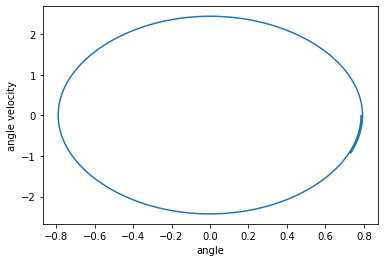

In [ ]:
# Comparing the filters

#Experiment with different settings of these paramters
dt = 0.001     #timestep size
numSteps = 2200 #number of time steps for simulation
#Process noise variance: R00: angle noise, R11: Velocity noise
R = np.diag([0,0])
#measurement noise variance
Q = [0.01]



G=10 #Nm/s^2. 
l = 1 #1 meter

# Instantiate two random number generators - one for process
# noise and other for measurement noise. Give seeds to allow
# for predictable sequence of random values across multiple runs.
# Helps debugging and reproducing results.
rng_p = np.random.default_rng(123)
rng_m = np.random.default_rng(345)


# Create pendulum
p = Pendulum(l=l, angl0=math.pi/4, avel0=0, G=G, R=R, Q=Q[0],rng_p=rng_p, rng_m=rng_m)


A = np.array([[1,dt],[-G/l*dt, 1]]) #linearization for small angles around 0 used in Kalman Filter
C = np.array([[1,0]]) #only angle is measured
B = np.array([[0,0],[0,1]])  #allow input only in velocity
P0 = np.diag([0.1,0.1])
mu0 = np.array([[math.pi/4],[0]])   #initial angle and angular velocity

# Instantiate Kalman Filter
kf = KalmanFilter(mu0=mu0,A=A, B=B, C=C, P0=P0, R=R, Q=Q)
# Instantiate Extended Kalman Filter
ekf = ExtendedKalmanFilter_Pendulum(mu0=mu0, B=B, C=C, P0=P0, R=R, Q=Q,G=G,l=l)

# Create some book keeping matrices for angle and velocity 
a = np.zeros(numSteps)
v = np.zeros(numSteps)
am = np.zeros(numSteps)
kferr = np.zeros(numSteps)
ekferr = np.zeros(numSteps)
kfaerr = np.zeros(numSteps)
ekfaerr = np.zeros(numSteps)
kfverr = np.zeros(numSteps)
ekfverr = np.zeros(numSteps)

akf = mu0
vkf = P0
aekf = mu0
vekf = P0
fig,ax = plt.subplots(1,1)
ax.set_xlabel("angle")
ax.set_ylabel("angle velocity")
for i in range(numSteps):
  p.step(dt)
  a[i],v[i] = p.getState() #true state of angle and angular velocity

  am[i] = p.measure() #measurement of the angle via sensor (has added noise)

  #run kalman filter passing in the measurement of angle
  kf.step([[0],[0]], np.atleast_1d(am[i])) 
  mukf, pkf = kf.probe() #state as estimated by kalman filter

  #squared error between estimate and true state
  kfaerr[i] = mukf[0][0]-a[i]
  kfverr[i] = mukf[1][0]-v[i]

  #run EKF passing in the measurement of angle
  ekf.step(dt,[[0],[0]], np.atleast_1d(am[i]))
  muekf, pekf = ekf.probe()

  #squared error between estimate and true
  ekfaerr[i] = muekf[0][0]-a[i]
  ekfverr[i] = muekf[1][0]-v[i]

print("KF RMS Error=", math.sqrt((kfaerr**2+kfverr**2).sum()/numSteps))
print("EKF RMS Error=", math.sqrt((ekfaerr**2+ekfverr**2).sum()/numSteps))

plt.plot(a,v)

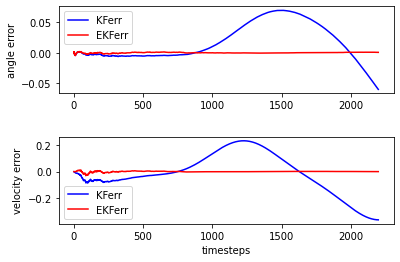

In [ ]:
fig, (ax1,ax2) = plt.subplots(2,1)
fig.subplots_adjust(hspace=0.5)
t = np.arange(numSteps)
ax1.plot(t,kfaerr,'b',ekfaerr,'r')
ax1.set_ylabel("angle error")
ax1.legend(("KFerr", "EKFerr"))

ax2.plot(t,kfverr,'b',ekfverr,'r')
ax2.set_ylabel("velocity error")
ax2.set_xlabel("timesteps")
ax2.legend(("KFerr", "EKFerr"))
plt.show()



**Tabulating the rms error for the two filters**

\begin{array} {|c|c|c|c||c|c|}
\hline
dt & R_{00} & R_{01} & Q & KFRMSErr & EKFRMSErr \\
\hline
0.001 & 0 & 0 & 0.01 & 0.15660063182018705 & 0.003828537633710865  \\
0.01 & 0 & 0 & 0.01 & 2.8310239322758326 & 0.004802010442919745  \\
0.001 & 0 & 0.0 & 0.1 & 0.16059848137667068 & 0.01811557558120448  \\
0.001 & 0 & 0.01 & 0.01 & 0.6179739782582148 & 0.6023113856860389  \\
0.001 & 0.01 & 0.0 & 0.01 & 56.494675485606784 & 0.05097314767364174  \\
\hline
\end{array}

**Conclusion**
The Kalman filter (KF) is a method based on recursive Bayesian filtering where the noise in your system is assumed Gaussian. The Extended Kalman Filter (EKF) is an extension of the classic Kalman Filter for non-linear systems where non-linearity are approximated using the first or second order derivative.

Since EKF can handle non-linearity of model.Hence, we can see the superiority of EKF with respect to Kalman filter. Furthermore, At smaller time steps RMS errors are also lowered upto some extent for both EKF and KF.
Noise in the R00 are impacting KF filter adversly in terms of RMS error.

In General, The highly noisey impact accuracies of both EKF and KF. 

